Data from many different sources. This notebook makes the last plot of
the paper.

TODO: need to drop duplicates between RL & CEL regions, note that RL and CEL not consistent as labeled 
also would be nice to seperate RL by galaxy? and high z as well

# Introduction

In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import vice


In [3]:
from surp import ViceModel, yields, subgiants, DATA_DIR
from surp import gce_math as gcem

import surp
import arya
from arya import COLORS

In [4]:
from singlezone import run_singlezone, exp_sfh

In [5]:
def to_nice(apogee_name):
    return "[" + apogee_name.title().replace("_", "/") + "]"

In [6]:
def plot_abund_errs(df, x="O_H", y="C_O", **kwargs):
    xs = df[x].values
    ys =  df[y].values
    xerr = df[f"{x}_err"].values
    yerr = df[f"{y}_err"].values
    filt = ~np.isnan(xerr) 
    filt &= ~np.isnan(yerr)
    filt &= xerr > 0
    filt &= yerr > 0
    
    plt.errorbar(xs[filt], ys[filt], xerr=xerr[filt], yerr=yerr[filt], fmt="o", capsize=0, **kwargs)
    plt.xlabel(to_nice(x))
    plt.ylabel(to_nice(y))

In [7]:
def plot_sample(df, **kwargs):    
    plot_abund_errs(df, x="FE_H", y="O_FE", **kwargs)
    plt.show()
    
    plot_abund_errs(df, **kwargs)
    plt.show()
    
    plot_abund_errs(df, x="O_FE", **kwargs)
    plt.show()
    
    if "MG_FE" in df.columns:
        plot_abund_errs(df, x="O_H", y="O_MG", **kwargs)
        plot_abund_errs(df, x="MG_H", y="C_MG", **kwargs)
        plot_abund_errs(df, x="MG_FE", y="C_MG", **kwargs)
        plt.show()
                    

In [8]:
def calc_errs(df, idx=None):
    series = pd.Series()
    series["O_H_err"] = np.nanmean(df["O_H_err"])
    series["C_O_err"] = np.nanmean(df["C_O_err"])
    
    if idx is None:
        O_H = np.mean(df.O_H)
        C_O = np.mean(df.C_O)
        
        idx = np.argmin((df.O_H - O_H)**2 )#+ (df.C_O - C_O)**2)
        series["O_H"] = df.O_H.iloc[idx]
        series["C_O"] = df.C_O.iloc[idx]
    
    return series.to_frame().T

In [9]:
def plot_sample_err(df, df_err=None, color=COLORS[0], edgecolors=None, marker="*", label="", **kwargs):
    if edgecolors is None:
        edgecolors = color
        
    if df_err is None:
        df_err = calc_errs(df)
        
    plt.scatter(df["O_H"], df["C_O"], marker=marker, color=color, edgecolors=edgecolors, label=label, **kwargs)
    

    plt.errorbar(df_err["O_H"], df_err["C_O"],  xerr=df_err.O_H_err, yerr=df_err.C_O_err,
             marker="none", ls="none", color=color, capsize=0, **kwargs)
    
    plt.xlabel("[O/H]")
    plt.ylabel("[C/O]")

In [10]:
surp.set_yields(verbose=False)

In [11]:
all_stars = pd.read_csv("data_analysis/amarsi19_cleaned.csv")

In [12]:
all_star_err = pd.DataFrame()


# split into two regemes and plot error bars
mh_cut = -0.3

low_z = all_stars[all_stars["O_H"] < mh_cut]
high_z = all_stars[all_stars["O_H"] >= mh_cut]
all_star_err = pd.concat([calc_errs(low_z), calc_errs(high_z)], ignore_index=True)
all_star_err

,O_H_err,C_O_err,O_H,C_O
0,0.023074,0.060948,-1.0091,-0.5907
1,0.018365,0.031701,0.0018,-0.0034


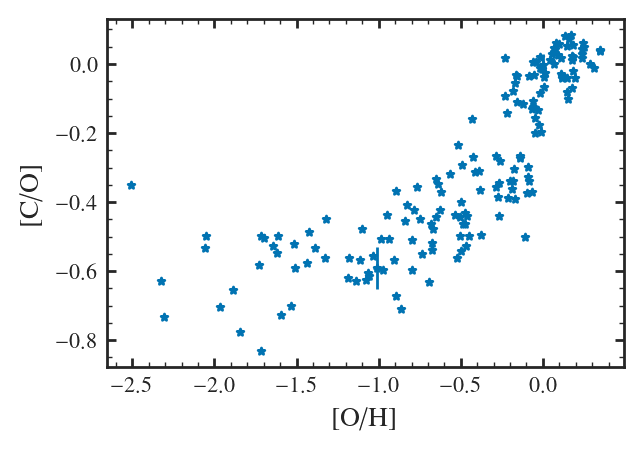

In [13]:
plot_sample_err(all_stars, all_star_err)

In [14]:
RL = pd.read_csv("data_analysis/RL_combined.csv")
RL = RL[~np.isnan(RL.C_O_err)]
RL_err = calc_errs(RL)

In [15]:
RL_mw = RL[RL.galaxy == "MW"]
RL_mw_err = calc_errs(RL_mw)

RL = RL[RL.galaxy != "MW"]
RL_err = calc_errs(RL)

In [16]:
np.sort(RL.galaxy.unique())

array(['LMC', 'M101', 'M31', 'M33', 'NGC 2366', 'NGC 2403', 'NGC 300',
       'NGC 5408', 'NGC 6822', 'SMC'], dtype=object)

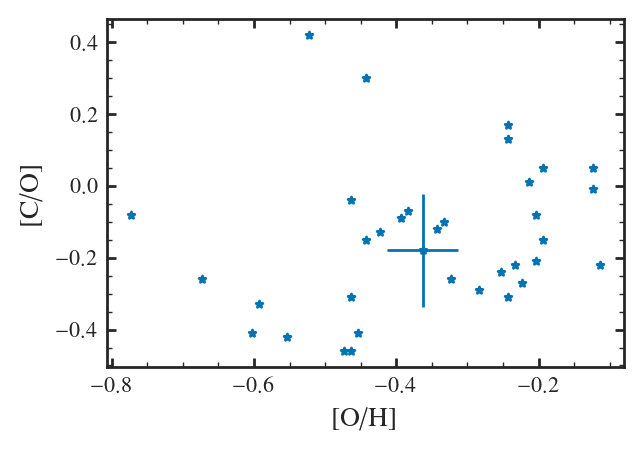

In [17]:
plot_sample_err(RL, RL_err)

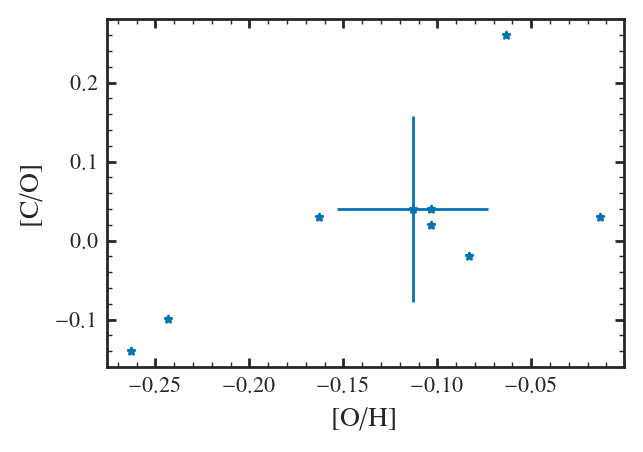

In [18]:
plot_sample_err(RL_mw, RL_mw_err)

In [19]:
DLA = pd.read_csv("data_analysis/DLA_combined.csv")
DLA = DLA[~np.isnan(DLA.C_O_err)]

DLA_err = calc_errs(DLA)

In [20]:
DLA.loc[6].log_OI

np.float64(12.06)

In [21]:
DLA.sort_values("C_O")[["galaxy", "study", "C_O", "O_H"]]

,galaxy,study,C_O,O_H
13,J0953-0504,dutta+14,-0.54963,-2.673177
2,J0955+4116,welsh+2022,-0.50963,-2.573177
11,J0311-1722,cooke+11,-0.46963,-2.413177
12,J1001+0343,cooke+11,-0.45963,-2.773177
8,Q2059-360,dessauges-zavadsky+03,-0.45963,-1.483177
16,Q0913+072,pettini+08,-0.43963,-2.523177
19,Q2206-199,pettini+08,-0.42963,-2.193177
10,J0903+2628,cooke+17,-0.42963,-3.173177
3,J0140-0839,ellison+10,-0.34963,-2.873177
9,J2155+1358,dessauges-zavadsky+03,-0.33963,-1.923177


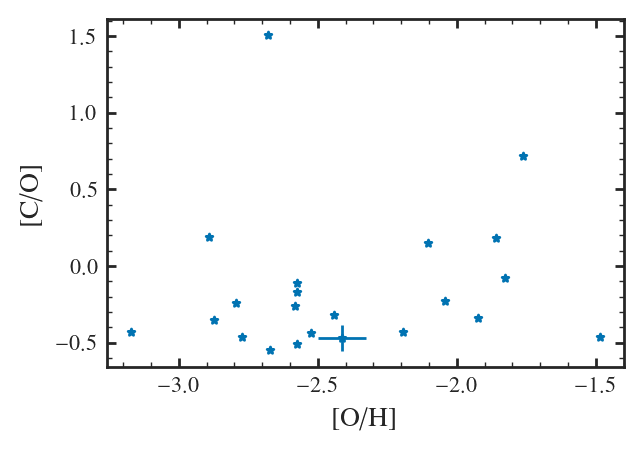

In [22]:
plot_sample_err(DLA, DLA_err)

In [23]:
CEL = pd.read_csv("data_analysis/CEL_combined.csv")
CEL_filt = ~np.isin(CEL.galaxy, RL.galaxy.unique())
CEL_filt &= ~np.isnan(CEL.C_O_err)
CEL = CEL[CEL_filt]
CEL_err = calc_errs(CEL)

FileNotFoundError: [Errno 2] No such file or directory: 'data_analysis/CEL_combined.csv'

In [ ]:
CEL.galaxy.unique()

In [ ]:
plot_sample_err(CEL, CEL_err)

In [ ]:
plot_sample_err(CEL[CEL.study != "pena-guerreno+17"], CEL_err)
plot_sample_err(CEL[CEL.study == "pena-guerreno+17"], CEL_err, color="green")

In [24]:
CEL.sort_values("C_O")[["region", "galaxy", "O_H", "C_O", "study"]]

NameError: name 'CEL' is not defined

In [25]:
high_z = pd.read_csv("data_analysis/high_z_cleaned.csv")
high_z = high_z[~np.isnan(high_z.C_O_err)]

high_z_err = calc_errs(high_z)

In [ ]:
plot_sample_err(high_z, high_z_err)

# Fiducial model

In [ ]:
subgiants_ha = subgiants[subgiants.high_alpha]

fiducial = ViceModel.from_file("../models/fiducial/run/model.json")

In [ ]:
h_today = fiducial.history[fiducial.history.time == np.max(fiducial.history.time)]
h_today = h_today[(h_today.R > 1) & (h_today.R < 15.5)].sort_values("R")
h_today

In [ ]:
def plot_fiducial():
    plt.plot(h_today.MG_H, h_today.C_MG, label="Model (present day)", zorder=9, lw=1.5, color=arya.style.COLORS[0])
    
plot_fiducial()

Parameters from james et al. dwarf paper:

- $\tau_{\rm in} = 1.01 \pm 0.13\,$Gyr
- $\eta = 8.8 \pm 0.9$
- $\tau_{\star} = 16.1 \pm 1.3\,$Gyr
- $\tau_{\rm end} = 5.4\pm0.3\,$Gyr
- $y_{\rm Fe}^{\rm cc} = 7.8\pm0.4 \times 10^{-4}$
- $y_{\rm Fe}^{\rm Ia} = 1.2\pm0.1\times 10^{-3}$

As we assume different O yields, we adjust $\eta$ accordingly. Our total O yields are 0.712e-3, so
$$
\frac{\eta}{
\eta_{\rm J+22}
} = 
\frac{y_O}{y_{\rm O, J+22}} = \frac{0.712}{1}
$$
in agrement with the difference in alpha-abundance assumptions. 
$$
\eta = 6.2 \pm 0.7
$$

# Singlezone models

## TODO: pull these somehow from the singlezone notebook

In [ ]:
yp = surp.YieldParams.from_file("../models/analytic/mc_best/yield_params.toml")
surp.set_yields(yp)

sz_fiducial = run_singlezone()[1]

change dwarf parameters to
match Wukong from James’ dwarf paper. 𝜂 = 47.99 ± 5, 𝑡end = 3.36 ± 0.5,
𝜏★ = 44.97 ± 7, 𝜏sfh = 3.08 ± 1

In [ ]:
48 * 0.6

In [ ]:
yp_lowz = surp.YieldParams.from_file("../models/analytic/linear/yield_params.toml")

surp.set_yields(yp_lowz)

y_scale = 0.6# 0.712

sz_models = [
    run_singlezone(verbose=True)[1],
    run_singlezone(eta=y_scale * 9.56, t_end=10.73, tau_star=26.60, tau_sfh=2.18, sfh=exp_sfh(None), mode="ifr", verbose=True)[1], # GSE
    run_singlezone(eta=y_scale * 48, t_end=3.4, tau_star=45, tau_sfh=3.08, sfh=exp_sfh(None), mode="ifr", verbose=True)[1], # wukong
]

In [ ]:
from surp.yields import calc_y

In [ ]:
MoverH = np.linspace(-5, 0.5)
Z = gcem.MH_to_Z(MoverH)

y_total = calc_y(Z)
y_agb = calc_y(Z, kind="agb")
y_cc = calc_y(Z, kind="cc")
y_ia = calc_y(Z, kind="ia")

yo = calc_y(ele="o")

In [ ]:
def plot_sz(zorder=10):
    #singlezone
    for i in range(len(sz_models)):
        out = sz_models[i]
        if i == 0:
            label="singlezone"
        else:
            label=""
        plt.plot(out.MG_H, out.C_MG, label=label, color="k", 
                 lw=1, zorder=zorder, ls=[":", "--", "-."][i])

    plt.plot(sz_fiducial.MG_H, sz_fiducial.C_MG, label=label, color="k", 
             lw=1, zorder=zorder)
    
    plt.xlabel("[O/H]")
    plt.ylabel("[C/O]")

In [ ]:
sz_models[1]

In [ ]:
for model in sz_models:
    plt.plot(model.time, model.sfr / model.sfr.iloc[-1])
plt.xlabel("time")
plt.ylabel("sfr")

In [ ]:
for model in sz_models:
    plt.plot(model.time, model.ifr / model.ifr.iloc[1], alpha=0.5)
plt.xlabel("time")
plt.ylabel("ifr")

In [ ]:
for model in sz_models:
    plt.plot(model.time, model.MG_H,  alpha=0.5)
plt.xlabel("time")
plt.xscale("log")
plt.ylabel("[Mg/H]")

In [ ]:
plot_sz(zorder=0)


plt.plot(MoverH, gcem.abund_ratio_to_brak(y_cc/yo, "c", "o"), lw=1, label="CC")
plt.plot(MoverH, gcem.abund_ratio_to_brak(y_total/yo, "c", "o"), lw=1, label="total")


plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")
plt.xlim(-4)
arya.Legend(-1)

In [ ]:
data_kwargs = dict(
    stat="median",
    label = r"low $\alpha$ subgiants",
    color=COLORS[4],
    err_kwargs=dict(facecolor=COLORS[4], alpha=0.0)
)

def cooh_subgiants(x="O_H", y="C_O", filt_ha=True, **kwargs):
    kwargs = dict(numbins=20, **kwargs)
    
    if filt_ha:
        df = surp.filter_high_alpha(subgiants)
    else:
        df = subgiants
        
    arya.medianplot(df, x=x, y=y, zorder=-2, **data_kwargs, **kwargs)

In [ ]:
cooh_subgiants()

# La Finale

In [ ]:
def lower_legend_label(fig):
    plt.ylabel(r"[C/O]")

    lab = plt.xlabel(r"[O/H]")
    
    leg = fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncols=4, markerscale=2)
    box1 = leg.get_tightbbox()
    box2 = lab.get_tightbbox() 

    t1 = box1.transformed(fig.transFigure.inverted())
    t2 = box2.transformed(fig.transFigure.inverted())
    ym = (t2.y0 + t1.y1)/2


    fig.add_artist(mpl.lines.Line2D([t1.x0, t1.x1], [ym, ym], color="k", lw=0.5))


In [ ]:
def plot_all_data():
    plot_sample_err(all_stars, all_star_err, marker="*", color=COLORS[8], label="MW stars")
    plot_sample_err(RL_mw, marker="p", color=COLORS[1], label="MW HII Regions")
    df = RL_mw.sort_values("O_H")
    plt.plot(df.O_H, df.C_O, color=COLORS[1])
    
    plot_sample_err(RL, marker="d", edgecolors=COLORS[2], color="none", lw=0.5, label="HII Regions (RL)")
    plot_sample_err(CEL, CEL_err, marker="d", color=COLORS[2], label="HII regions (CEL)")

    for galaxy in RL.galaxy.unique():
        df = RL[RL.galaxy == galaxy].sort_values("O_H")
        if len(df) > 2:
            print(galaxy)
            #plt.plot(df.O_H, df.C_O, color=COLORS[2])

    plot_sample_err(high_z, high_z_err, marker="s", color=COLORS[6], label=r"high-$z$ galaxies")
    
    
    plot_sample_err(DLA, DLA_err, marker="^", color=COLORS[3], label=r"damped Lyman$\alpha$ systems")


    cooh_subgiants()

In [ ]:
fig = plt.figure(figsize=(7, 4))
plot_all_data()

lower_legend_label(fig)


In [ ]:
fig = plt.figure(figsize=(7, 4))

plot_all_data()
plot_fiducial()
plot_sz()

lower_legend_label(fig)
plt.xlim(-3.25, 0.5)
plt.ylim(-1.2, 0.4)
plt.tight_layout()


plt.savefig("figures/summary.pdf")

# Low z mean

In [ ]:
all_data = pd.concat([
    RL_mw,
    RL,
    DLA, 
    all_stars,
    high_z,
    CEL,
])

In [ ]:
w = 1 / all_data.C_O_err**2

filt = all_data.O_H < -1
filt &= all_data.O_H > -1.8

w  = w[filt]
x = all_data.C_O[filt]

In [ ]:
μ = np.sum(x*w) / np.sum(w)
σ = 1/np.sqrt(np.sum(w))

μ, σ

In [ ]:
surp.gce_math.brak_to_abund_ratio(-0.62, "c", "mg") * vice.yields.ccsne.settings["mg"] / 1e-4

In [ ]:
surp.gce_math.brak_to_abund_ratio(-0.62, "c", "mg") * vice.yields.ccsne.settings["mg"] * σ*np.log(10)/ 1e-4

In [ ]:
vice.yields.ccsne.settings["mg"] * 10**-0.62 

In [ ]:
import weighted

In [ ]:
weighted.quantile(x, w, 0.16)

In [ ]:
plt.errorbar(all_data.O_H[filt], all_data.C_O[filt], yerr = 1/w**0.5, fmt="o")
plt.axhline(-0.62)